ENRON PROJECT

STEP 1: Preprocessing the data -  it's can take a while

In [1]:
###### import the libraries we need
import mailClass
import re
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import email
import pickle
import numpy as np
import email.utils
import pandas as pd
import networkx as nx
import streamlit as st
from typing import List
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.cluster import KMeans
from collections import defaultdict
import community as community_louvain
from networkx.algorithms import community as nx_comm
from scipy.cluster.hierarchy import linkage, dendrogram
from pathlib import Path
import os
from networkx.algorithms.community import modularity





In [2]:
# Download NLTK data files (only need to run once)
nltk.download('punkt')

emails_df = pd.read_csv('emails.csv')
## now we pass every row of the dataframe to the mailClass
emails_df['mail_object'] = emails_df['message'].map(lambda x:mailClass.Enron_mail(x))
## get the user of the sender
emails_df['user'] = emails_df['file'].map(lambda x: x.split('/')[0])
##get the mail of the sender
emails_df['mail_from'] = emails_df['mail_object'].map(lambda x:x.get_from())
##get the mail of the receiver
emails_df['mail_to'] = emails_df['mail_object'].map(lambda x :x.get_to())
##get the date of object of the mail
## object of date is a datetime objects.
emails_df['mail_date'] = emails_df['mail_object'].map(lambda x:x.get_date())
##get string date
emails_df['mail_date_str'] = emails_df['mail_object'].map(lambda x:x.get_string_date())
##get the subject of the mail
emails_df['mail_subject'] = emails_df['mail_object'].map(lambda x:x.get_subject())
##get the body of the mail
emails_df['mail_content'] = emails_df['mail_object'].map(lambda x:x.get_content())
#drop the mail_object column
emails_df.drop(['message','file'],axis=1,inplace=True)



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaelmessika/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


at this part we will filter the data to keep only the mails that were sent from the enron domain
because we want to explore the inside of the company

In [3]:
def filter_enron_senders(emails_df):
    """
    :param emails_df: the emails dataframe
    :return: emails_df: the emails dataframe with only emails sent from Enron domain
    """
    # Filter the DataFrame to keep only emails from senders with "@enron.com" domain
    enron_emails_df = emails_df[emails_df['mail_from'].str.contains('@enron.com', na=False)]
    
    # Print the number of remaining emails
    print(f"Number of emails with Enron domain: {len(enron_emails_df)}")
    
    return enron_emails_df

# Apply the filter
emails_df = filter_enron_senders(emails_df)


Number of emails with Enron domain: 427785


STEP 2: We will show how the data looks like as a dataframe with the first 5 rows after the preprocessing.

In [4]:
emails_df.head(5)

,mail_object,user,mail_from,mail_to,mail_date,mail_date_str,mail_subject,mail_content
0,<mailClass.Enron_mail object at 0x7fae0a219e80>,allen-p,phillip.allen@enron.com,tim.belden@enron.com,2001-05-14 16:39:00-07:00,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",,Here is our forecast
1,<mailClass.Enron_mail object at 0x7fae0a219b50>,allen-p,phillip.allen@enron.com,john.lavorato@enron.com,2001-05-04 13:51:00-07:00,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Re:,Traveling to have a business meeting takes the...
2,<mailClass.Enron_mail object at 0x7fade8da9100>,allen-p,phillip.allen@enron.com,leah.arsdall@enron.com,2000-10-18 03:00:00-07:00,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",Re: test,test successful. way to go!!!
3,<mailClass.Enron_mail object at 0x7fade8da9430>,allen-p,phillip.allen@enron.com,randall.gay@enron.com,2000-10-23 06:13:00-07:00,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",,"Randy,\n\n Can you send me a schedule of the s..."
4,<mailClass.Enron_mail object at 0x7fade8da9490>,allen-p,phillip.allen@enron.com,greg.piper@enron.com,2000-08-31 05:07:00-07:00,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",Re: Hello,Let's shoot for Tuesday at 11:45.


STEP 3: We will show how 1 mail looks like in the database


In [5]:
print(emails_df['mail_object'][0].get_message())

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


STEP 4: Data Exploration



1.first we will look and see for every year how many mails were sent
we will use the mail_date column to get the year of the mail
and plot the data with matplotlib

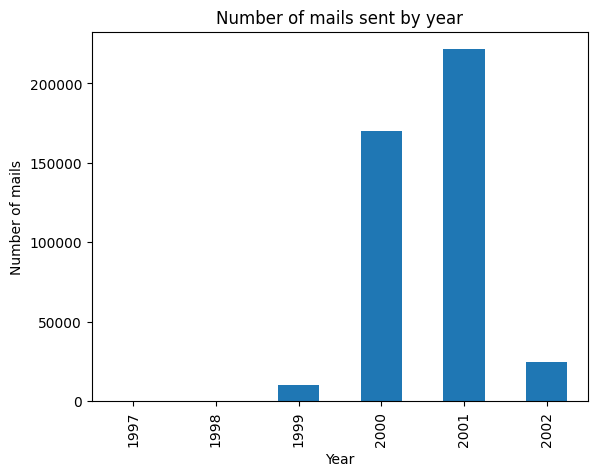

In [6]:
import matplotlib.pyplot as plt
"""
in this part ew will explore the number of mails sent by year 
2005 and after 1980 because we want to look the mails clothes to the enron scandal
"""
# Filter emails sent between 1980 and 2005
filtered_emails = emails_df[(emails_df['mail_date'].apply(lambda x: x.year) > 1980) & (emails_df['mail_date'].apply(lambda x: x.year) < 2005)]
############################################################################
# Group by year and count the number of emails
emails_per_year = filtered_emails['mail_date'].apply(lambda x: x.year).value_counts().sort_index()
# Plot the data
emails_per_year.plot(kind='bar')
plt.title('Number of mails sent by year')
plt.xlabel('Year')
plt.ylabel('Number of mails')
plt.show()
plt.savefig('mails_per_year.png')
############################################################################

2.we will look and see for every month in 2001 when the enron scandal happened how many mails were sent


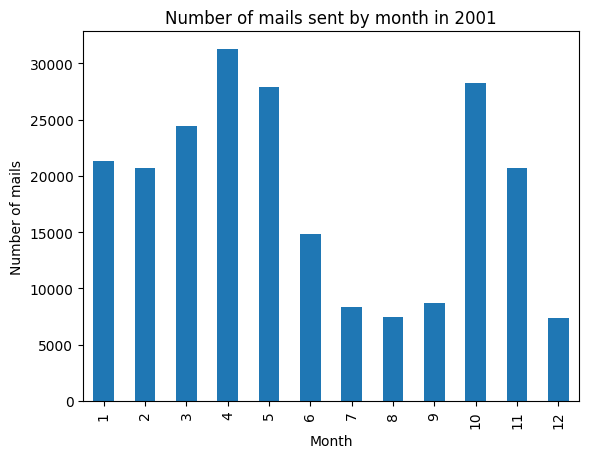

In [7]:
"""
in this part we will explore all the mails sent by month in 2001 and plot the data"""
############################################################################
## we will explore here all the mails sent by month in 2001
filtered_emails = emails_df[(emails_df['mail_date'].apply(lambda x: x.year) == 2001)]
## now we will group by month and count the number of mails
emails_per_month = filtered_emails['mail_date'].apply(lambda x: x.month).value_counts().sort_index()
## plot the data
emails_per_month.plot(kind='bar')
plt.title('Number of mails sent by month in 2001')
plt.xlabel('Month')
plt.ylabel('Number of mails')
plt.savefig('mails_per_month_year_2001.png')
plt.show() 
############################################################################

3.we will look and see for every day in the week how many mails were sent

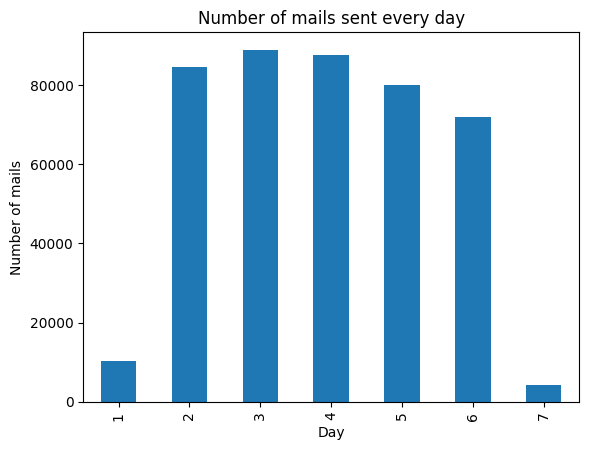

In [8]:
##now we will explore the number of mails sent every day
emails_per_user = emails_df['mail_object'].apply(lambda x:x.get_day_week()).value_counts().sort_index()
##plot the data
emails_per_user.plot(kind='bar')
plt.title('Number of mails sent every day')
plt.xlabel('Day')
plt.ylabel('Number of mails')
plt.show()



at this part we going to clean the mail body and do sentiment analysis on the mail body over the years 1999 - 2002.


    

In [48]:
"""
function which takes a list of years and returns a subset of the emails dataframe containing only the emails from those years
and adds a new column 'clean_content' which contains the cleaned version of the email content
returns the subset dataframe
"""
def make_subset_df(years):
    subset_emails_df = emails_df[emails_df['mail_date'].apply(lambda x: x.year in years)].copy()
    subset_emails_df.loc[:, 'clean_content'] = subset_emails_df['mail_content'].map(clean_text)
    subset_emails_df.loc[:, 'year_month'] = subset_emails_df['mail_object'].map(lambda x: str(x.get_year_month()))
    return subset_emails_df




# Enhanced clean_text function
"""
function to clean the text by removing non-alphabet characters, digits, and extra spaces
and converting the text to lowercase
"""
def clean_text(text):
    """
    :param text: one mail content to clean
    :return: cleaned text
    """
    # Remove non-alphanumeric characters except for spaces and basic punctuation
    text = re.sub(r"[^a-zA-Z0-9,.?!'\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    # Replace newlines and multiple spaces with a single space
    text = re.sub(r"[\s]+", " ", text).strip()
    return text


### now we will use the vader sentiment analysis to do the sentiment analysis
### we do it in year 2002 after the enron scandal was discovered
### we take random sample of 10% of the data because it's take a while to do the sentiment analysis
def create_sentiment_analyse(sample_percent=1, years = [2000, 2001, 2002]):
    """
    :param sample_percent: percent of the data to sample
    :param years: years to include in the analysis
    :return: new dataframe with sentiment analysis results on the 'clean_content' column
    with a new 'compound' column containing the compound sentiment score
    ont the years in the list
    """
    subset_emails_df = make_subset_df(years)
    analyzer = SentimentIntensityAnalyzer()
    small_subset_df = subset_emails_df.sample(frac=sample_percent, random_state=1)
    # Perform sentiment analysis
    small_subset_df['vader'] = small_subset_df['clean_content'].map(lambda x: analyzer.polarity_scores(x))
    small_subset_df['compound'] = small_subset_df['vader'].map(lambda x: x['compound'])
    return small_subset_df
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

##### create the sentiment analysis and data frame subset_data
"""
on the plotting pdf we will use on 100 percent of the data but when you run the cod you should
 take less percent because it's take a while about 10 and more hours so you need to take about 10 percent of the data
so deafault is 1 percentm of the data"""
subset_data = create_sentiment_analyse(years =  [1999, 2000, 2001, 2002], sample_percent=0.01)


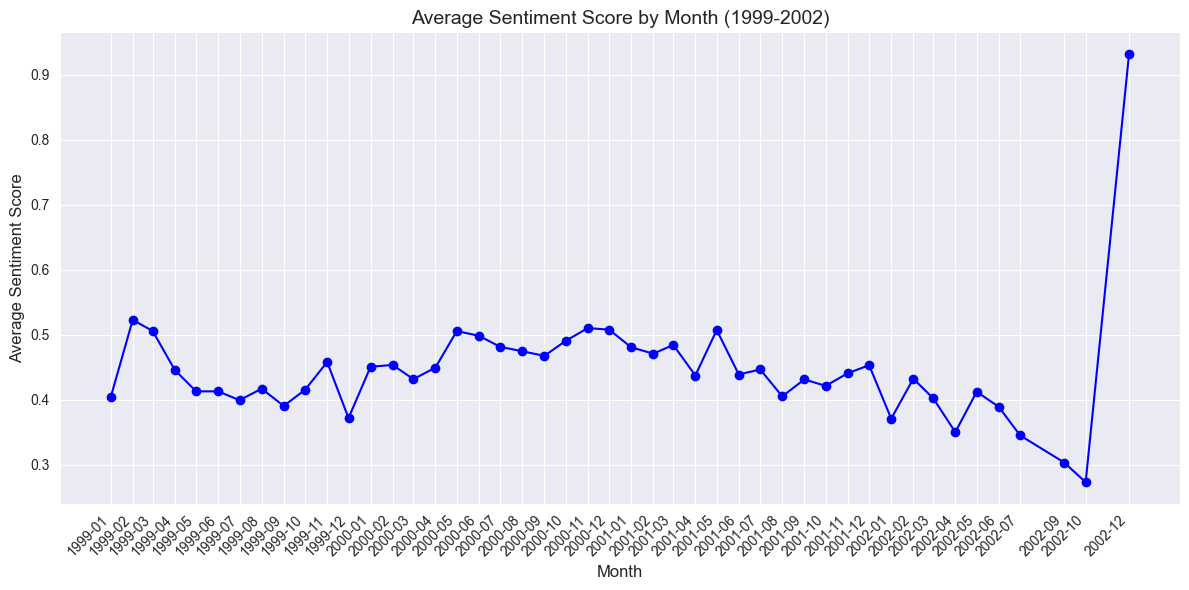

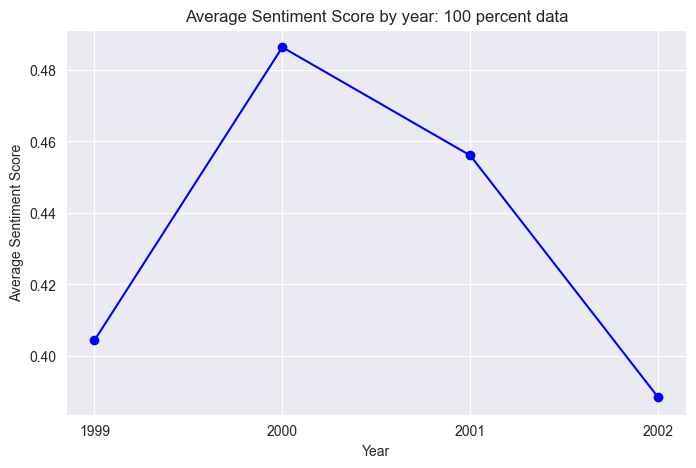

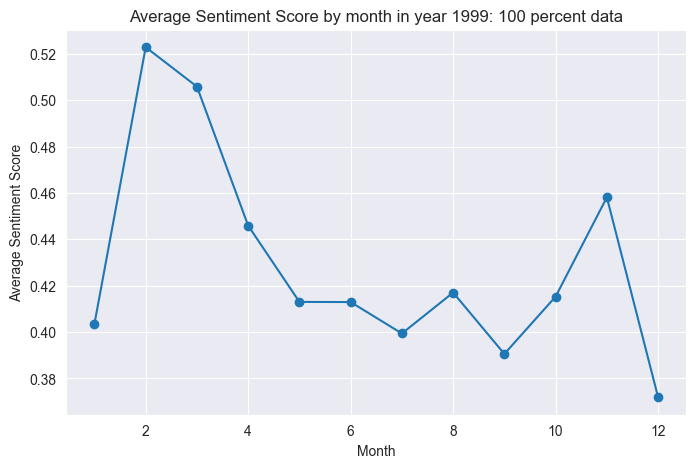

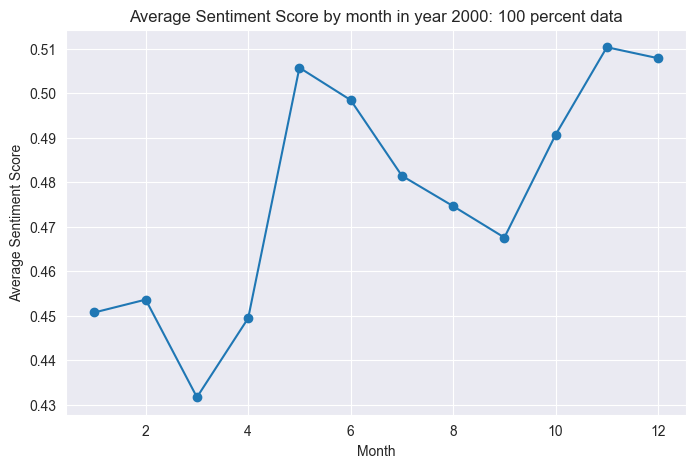

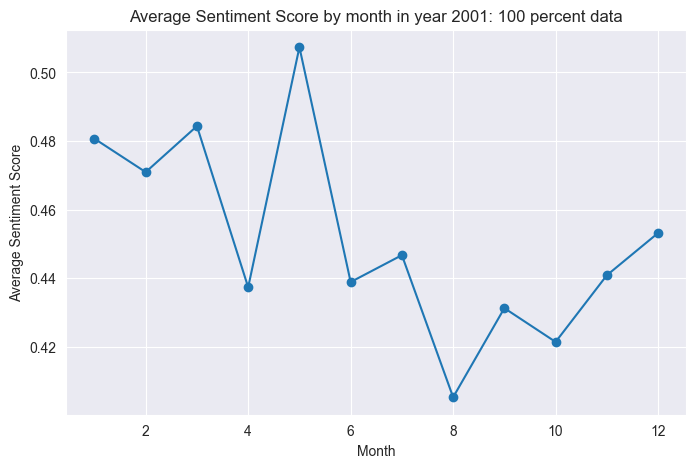

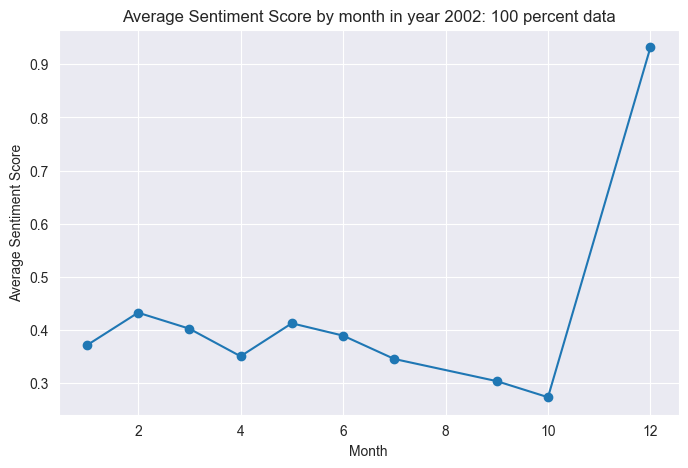

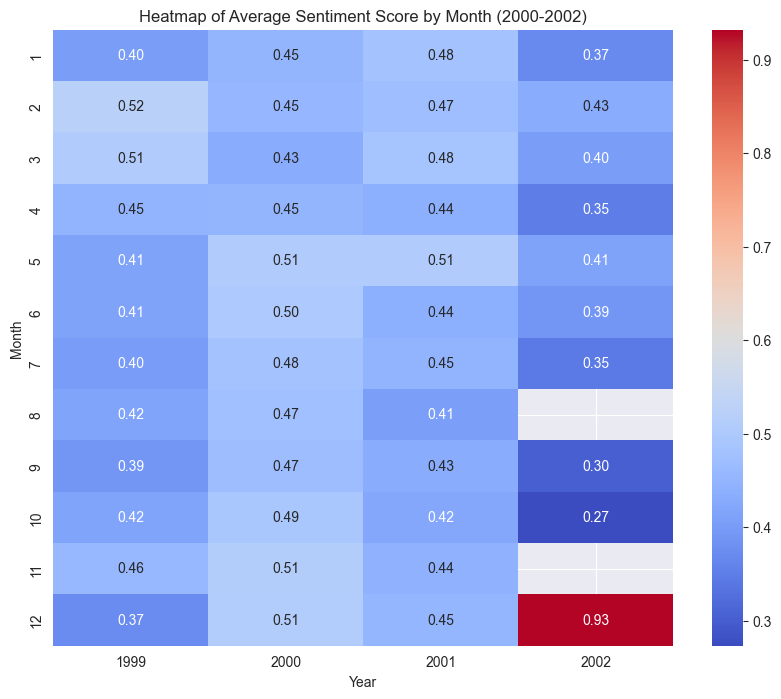

In [115]:
"""
at this part we will plot the sentiment analysis over the years and the sentiment analysis over the months in the year
we use in tools like plotly and matplotlib to plot the data"""


def plot_data_avg_years(subset_data, title, x_label, y_label):
    """
    :param subset_data: data frame with the sentiment analysis results 
    :param title: the title of the plot
    :param x_label: x axis label
    :param y_label: y axis label
    the function plot the average sentiment score by year
    """
    # Create a new column 'year' and extract year from 'mail_object'
    subset_data['year'] = subset_data['mail_object'].map(lambda x: x.get_year())

    # Group by 'year' and calculate average sentiment
    avg_sentiment = subset_data.groupby('year')['compound'].mean()

    # Plot the average sentiment by year
    plt.figure(figsize=(8, 5))
    plt.plot(avg_sentiment.index, avg_sentiment.values, marker='o', color='b')

    # Set the x-ticks to be the years (integers)
    plt.xticks(avg_sentiment.index)

    # Add labels and title
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)  # Optionally, add grid for better readability

    # Show the plot
    plt.savefig('sentiment_analysis_year.png')
    plt.show()
    
    
    
    
def plot_data_avg_month_for_single_year(subset_data, title, x_label, y_label, year):
    """
    :param subset_data: the data frame with the sentiment analysis results
    :param title: the title of the plot
    :param x_label: the x axis label
    :param y_label: the y axis label
    :param year: the year we want to plot the data
    the function plot the average sentiment score by month in the given year
    """
    # Filter the data for the given year and create a copy to avoid SettingWithCopyWarning
    year_subset_data = subset_data[subset_data['mail_object'].map(lambda x: int(x.get_year())) == year].copy()
    
    # Add a 'month' column by extracting the month from 'mail_object'
    year_subset_data.loc[:, 'month'] = year_subset_data['mail_object'].map(lambda x: x.get_month())
    
    # Group by 'month' and calculate average sentiment
    avg_sentiment = year_subset_data.groupby('month')['compound'].mean()
    
    # Plot the average sentiment by month
    plt.figure(figsize=(8, 5))
    avg_sentiment.plot(kind='line', marker='o')
    
    # Add labels and title
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    # Save the plot
    plt.savefig(f'sentiment_analysis_month_in_year_{year}.png')
    
    # Show the plot
    plt.show()
    

import seaborn as sns

def plot_heatmap_sentiment(subset_data):
    """
    function to plot a heatmap of the average sentiment score by month and year 
    """
    subset_data['year'] = subset_data.loc[:,'mail_object'].map(lambda x :x.get_year())
    subset_data['month'] = subset_data.loc[:,'mail_object'].map(lambda x :x.get_month())
    avg_sentiment_by_month_year = subset_data.groupby(['year', 'month'])['compound'].mean().unstack(level=0)

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(avg_sentiment_by_month_year, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title('Heatmap of Average Sentiment Score by Month (2000-2002)')
    plt.xlabel('Year')
    plt.ylabel('Month')
    plt.savefig('heatmap_sentiment.png')
    plt.show()
    

import matplotlib.pyplot as plt

def plot_monthly_sentiment(subset):
    """
    Function to plot the average sentiment score by month using an existing 'year-month' column.
    
    Parameters:
    emails_df (DataFrame): The dataframe containing 'year-month' (as a string) and 'compound' sentiment scores.
    
    Returns:
    None: Displays a plot of average sentiment by month.
    """
    
    # Convert 'year-month' from string to datetime for proper plotting
    subset['year_month'] = pd.to_datetime(subset['year_month'], format='%Y-%m')
    
    # Group by 'year_month' and calculate the average sentiment for each month
    monthly_sentiment = subset.groupby('year_month')['compound'].mean().reset_index()
    
    
    # Convert 'year_month' back to a string format to remove the day component
    monthly_sentiment['year_month_str'] = monthly_sentiment['year_month'].dt.strftime('%Y-%m')
    
    
     # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_sentiment['year_month'], monthly_sentiment['compound'], marker='o', color='b')
    
    # Set the x-axis to show all months without days
    plt.xticks(monthly_sentiment['year_month'], monthly_sentiment['year_month_str'], rotation=45, ha="right")
    
    # Add titles and labels
    plt.title('Average Sentiment Score by Month (1999-2002)', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Average Sentiment Score', fontsize=12)
    
    # Display the grid
    plt.grid(True)
    
    # Show the plot
    plt.tight_layout() 
    plt.savefig('monthly_sentiment.png')
    # Adjust layout to avoid label overlap
    plt.show()

# Example usage:
plot_monthly_sentiment(subset_data)
####plot the data avg over the years
##### OVER THE PDF PLOTS WE USE 100 PERCENT OF THE DATA BUT HERE WHEN U RUN THE CODE USE 1 PERCENT OF THE DATA BECAUSE IT'S TAKE A WHILE TO RUN THE CODE WITH 100 PERCENT OF THE DATA
sample_percent = 1
plot_data_avg_years(subset_data, f'Average Sentiment Score by year: {sample_percent} percent data', 'Year', 'Average Sentiment Score')

####plot the data for every year
plot_data_avg_month_for_single_year(subset_data, f'Average Sentiment Score by month in year 1999: {sample_percent} percent data', 'Month', 'Average Sentiment Score', year = 1999)
plot_data_avg_month_for_single_year(subset_data, f'Average Sentiment Score by month in year 2000: {sample_percent} percent data', 'Month', 'Average Sentiment Score', year = 2000)
plot_data_avg_month_for_single_year(subset_data, f'Average Sentiment Score by month in year 2001: {sample_percent} percent data', 'Month', 'Average Sentiment Score', year = 2001)
plot_data_avg_month_for_single_year(subset_data, f'Average Sentiment Score by month in year 2002: {sample_percent} percent data', 'Month', 'Average Sentiment Score', year = 2002)
###plot the heatmap
plot_heatmap_sentiment(subset_data)


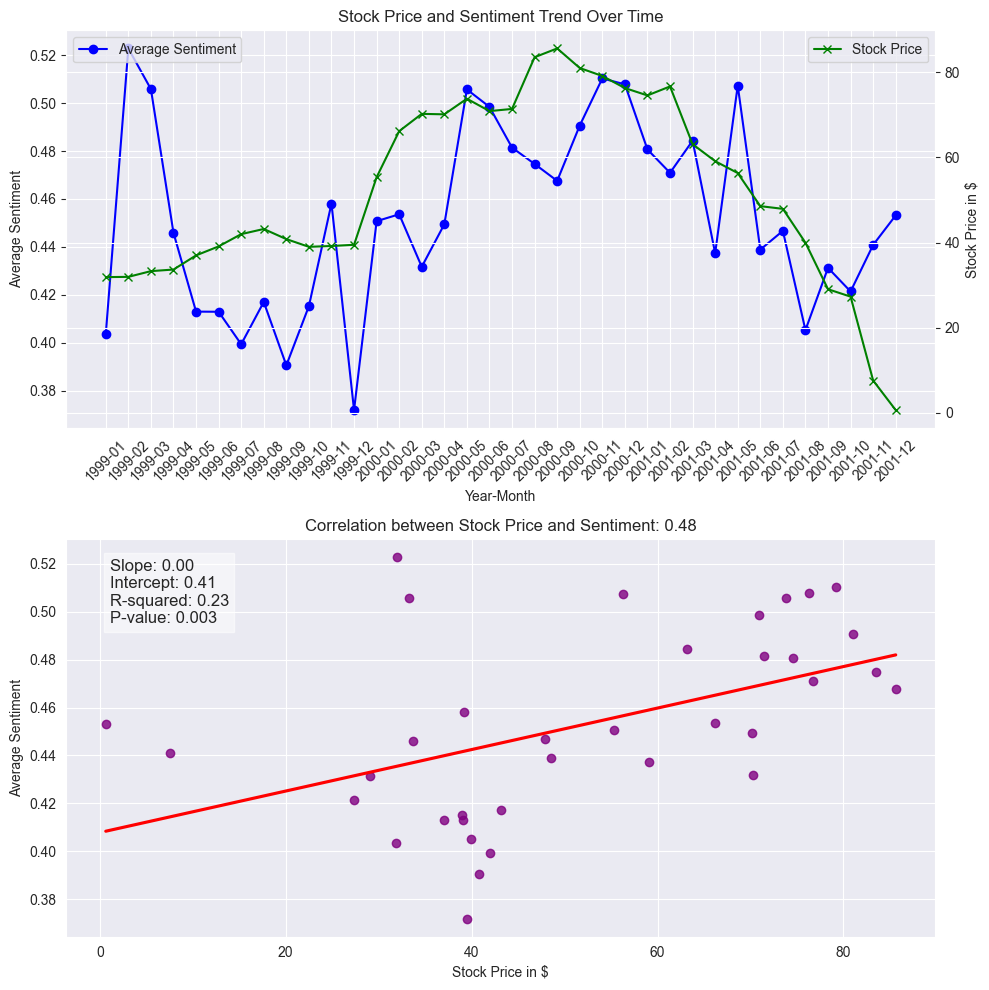

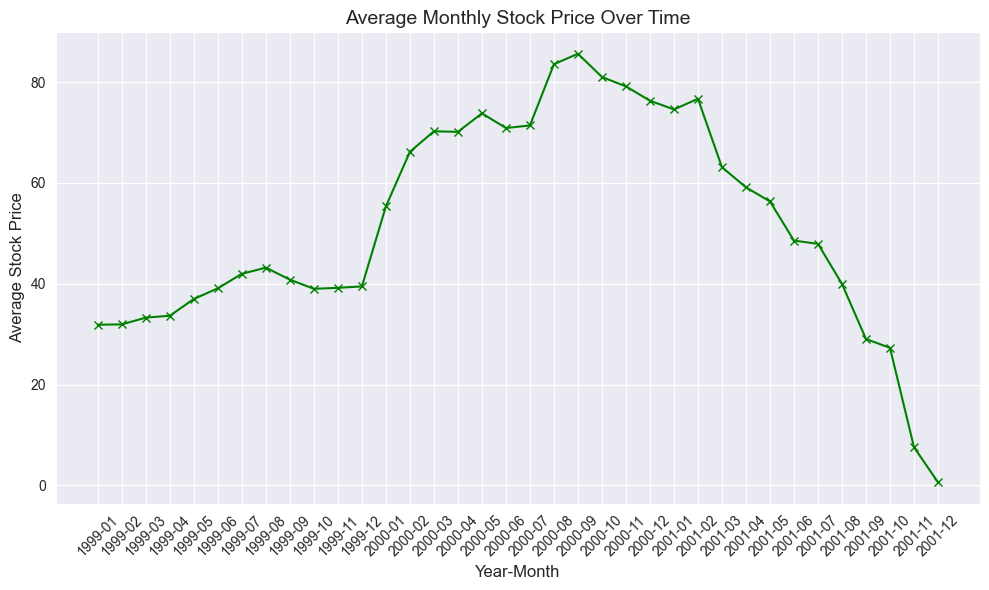

In [116]:
from scipy import stats  # Import the missing module
"""
in this part we explore the connection between the stock price and the sentiment analysis
we will use the stock price data and the sentiment analysis data
we will calculate the correlation between the stock price and the sentiment analysis
and plot the data
we will plot the data sentiment analysis and stock price over time and the correlation between them
also we will show the average stock price in month over time
"""
stock_data = pd.read_csv('enron_stock_price.csv')
# Clean the data by removing unnecessary columns
stock_data_cleaned = stock_data[['Date', 'close_val']].copy()

# Convert the 'Date' column to datetime format
stock_data_cleaned['Date'] = pd.to_datetime(stock_data_cleaned['Date'], format='%d.%m.%Y')

# Extract year and month for grouping
stock_data_cleaned['Year_Month'] = stock_data_cleaned['Date'].dt.to_period('M')

# Calculate the monthly average of the stock closing values
monthly_avg_stock = stock_data_cleaned.groupby('Year_Month')['close_val'].mean().reset_index()

# Convert 'year_month' to datetime format in case it's not already
subset_data['year_month'] = pd.to_datetime(subset_data['year_month'], format='%Y-%m')
#######finish the stock data cleaning

################################################################

# Group sentiment data by year-month and calculate the average sentiment for each month
monthly_avg_sentiment = subset_data.groupby(subset_data['year_month'].dt.to_period('M'))['compound'].mean().reset_index()
monthly_avg_sentiment.columns = ['Year_Month', 'avg_sentiment']

# Merge the monthly stock price data (from previous calculations) with the sentiment data
merged_data = pd.merge(monthly_avg_sentiment, monthly_avg_stock, on='Year_Month')

################################################################
# Calculate correlation between the average sentiment and the stock price
correlation = merged_data['close_val'].corr(merged_data['avg_sentiment'])

# Create visualizations: one for trends over time, another for correlation scatter plot with regression line
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Plot sentiment and stock price trends over time
ax[0].plot(merged_data['Year_Month'].astype(str), merged_data['avg_sentiment'], label='Average Sentiment', color='blue', marker='o')
ax[0].set_ylabel('Average Sentiment')   
ax[0].set_xlabel('Year-Month')
ax[0].tick_params(axis='x', rotation=45)

# Create a secondary y-axis for stock price with distinct color and label
ax2 = ax[0].twinx()
ax2.plot(merged_data['Year_Month'].astype(str), merged_data['close_val'], label='Stock Price', color='green', marker='x')
ax2.set_ylabel('Stock Price in $')

# Add legends for both lines
ax[0].legend(loc='upper left')
ax2.legend(loc='upper right')

ax[0].set_title('Stock Price and Sentiment Trend Over Time')

################################################################
# Scatter plot with regression line to show the correlation between stock price and sentiment
sns.regplot(x='close_val', y='avg_sentiment', data=merged_data, ax=ax[1], scatter_kws={'color':'purple'}, line_kws={'color':'red'}, ci=None)

# Calculate the linear regression stats
slope, intercept, r_value, p_value, std_err = stats.linregress(merged_data['close_val'], merged_data['avg_sentiment'])

# Add labels and title
ax[1].set_xlabel('Stock Price in $')
ax[1].set_ylabel('Average Sentiment')
ax[1].set_title(f'Correlation between Stock Price and Sentiment: {correlation:.2f}')

# Display regression statistics on the plot
ax[1].text(0.05, 0.95, f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}\nR-squared: {r_value**2:.2f}\nP-value: {p_value:.3f}', 
           ha='left', va='top', transform=ax[1].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig('correlation_stock_price_sentiment_with_regression_stats.png')
plt.show()

######################################################################


# Create a line plot for monthly average stock prices
plt.figure(figsize=(10, 6))

# Plotting the monthly average stock price over time
plt.plot(merged_data['Year_Month'].astype(str), merged_data['close_val'], label='Average Stock Price', color='green', marker='x')

# Add labels and title
plt.title('Average Monthly Stock Price Over Time', fontsize=14)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Average Stock Price', fontsize=12)

# Rotate x-ticks for better readability
plt.xticks(rotation=45)

# Add a grid for better visualization
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig('monthly_stock_price.png')
plt.show()


Number of highly negative emails: 3227
Number of highly positive emails: 84130


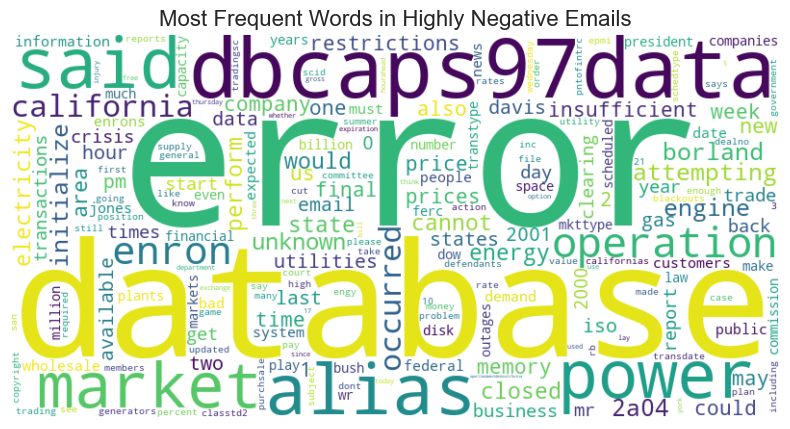

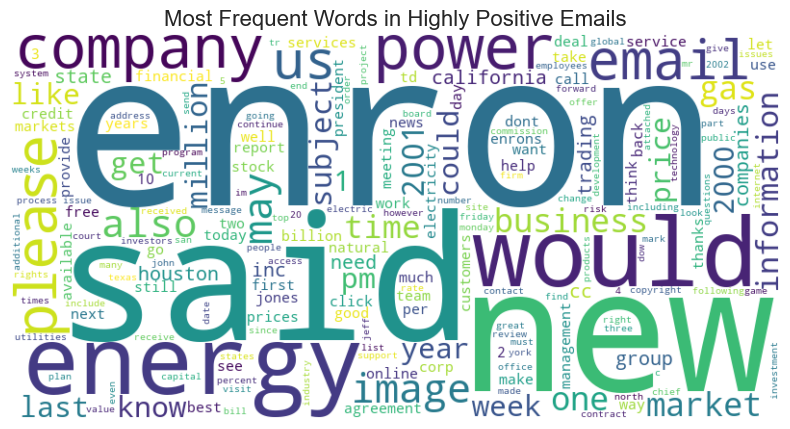

In [117]:
"""
at this part we will show the most frequent words in the highly positive and negative emails
we will use the vader sentiment analysis to get the highly positive and negative emails
and then we will use the wordcloud to show the most frequent words in the highly positive and negative emails"""

from collections import Counter
import re
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define thresholds for sentiment analysis
threshold_negative = -0.95  # Example threshold for negative sentiment
threshold_positive = 0.95   # Example threshold for positive sentiment

# Get highly positive and negative emails
negative_texts = subset_data[subset_data['compound'] < threshold_negative]['clean_content']
positive_texts = subset_data[subset_data['compound'] > threshold_positive]['clean_content']
print(f"Number of highly negative emails: {len(negative_texts)}")
print(f"Number of highly positive emails: {len(positive_texts)}")

# Join the text
negative_text = " ".join(negative_texts)
positive_text = " ".join(positive_texts)

# Function to clean text for WordCloud
def clean_text_for_tag_cloud(text):
    # Remove non-alphanumeric characters except for spaces
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    # Remove stopwords
    stopwords = set(nltk.corpus.stopwords.words('english'))
    text = " ".join([word for word in text.split() if word.lower() not in stopwords])
    return text

# Clean negative and positive texts
negative_text = clean_text_for_tag_cloud(negative_text)
positive_text = clean_text_for_tag_cloud(positive_text)

# Function to create and save a WordCloud from a frequency dictionary
def create_tag_cloud_from_freq(word_freq, title, save_name='tag_cloud.png'):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.savefig(save_name)
    plt.show()

# Create a word frequency dictionary for negative and positive texts
negative_word_freq = Counter(negative_text.split())
positive_word_freq = Counter(positive_text.split())

# Create WordClouds for negative and positive emails using the frequency dictionary
create_tag_cloud_from_freq(negative_word_freq, "Most Frequent Words in Highly Negative Emails", 'tag_cloud_negative.png')
create_tag_cloud_from_freq(positive_word_freq, "Most Frequent Words in Highly Positive Emails", 'tag_cloud_positive.png')





In [119]:
"""in this part will explor who is the most important person in the company
will use pagerank algorithm to find the most important person in the company
by make graph of the mails and the sender and receiver and use the pagerank algorithm to find the most important person in the 
company also we run betweenness centrality on the top nodes that find in pagerank"""
############################################################################
# Function to process the data and handle multiple recipients and null senders
def process_email_data(data):
    """
    :param data:data frame of the emails 
    :return: directed graph with edges representing email exchanges
    """
    G = nx.DiGraph()  # Directed graph

    for idx, row in data.iterrows():
        sender = row['mail_from']
        recipients = row['mail_to']
        ##if the sender is null or the recipients is null we will skip this mail
        if pd.isnull(sender) or not sender or not recipients:
            continue

        # Split recipients if there are multiple, separated by commas
        recipient_list = recipients.split(',') if isinstance(recipients, str) else []

        # Add edges to the graph for each recipient
        for recipient in recipient_list:
            recipient = recipient.strip()  # Remove leading/trailing whitespace
            if recipient:  # Only add valid recipients
                if G.has_edge(sender, recipient):
                    # If the edge already exists, increase the weight
                    G[sender][recipient]['weight'] += 1
                else:
                    # Otherwise, add the edge with an initial weight of 1
                    G.add_edge(sender, recipient, weight=1)
    return G




def remove_isolated_nodes(G, min_degree=2):
    """
    function to remove isolated nodes from the graph
    """
    low_degree_nodes = [node for node, degree in G.degree() if degree < min_degree]
    G.remove_nodes_from(low_degree_nodes)
    return G

############################################################################
# Function to remove isolated nodes (those with degree less than a specified threshold)
def remove_isolated_nodes(G, min_degree=2):
    """
    Removes nodes with degree less than the specified threshold.
    
    :param G: Graph to be filtered
    :param min_degree: Minimum degree to retain nodes
    :return: Filtered graph with nodes having at least min_degree
    """
    low_degree_nodes = [node for node, degree in G.degree() if degree < min_degree]
    G.remove_nodes_from(low_degree_nodes)
    return G


# Function to visualize PageRank with Plotly, showing In-Degree and Out-Degree from the original graph
def visualize_top_pagerank_plotly(G, top_n=30, calculate_betweenness=False):
    """
    this function to visualize the top pagerank with plotly
    run pagerank algorithm on the graph and visualize the top pagerank
    run betweenness centrality if calculate_betweenness is true on the top nodes that find in pagerank
    :param G: 
    :param top_n: 
    :param calculate_betweenness: 
    :return: 
    """
    # Calculate PageRank on the original graph
    pagerank_scores = nx.pagerank(G, weight='weight')

    # Calculate In-Degree and Out-Degree on the original graph
    original_in_degrees = dict(G.in_degree())
    original_out_degrees = dict(G.out_degree())


    # Get the top N nodes based on PageRank
    top_nodes = dict(sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:top_n])

    # Create a subgraph of the top N nodes
    top_graph = G.subgraph(top_nodes.keys())
     # Optionally calculate Betweenness Centrality on the original graph
    if calculate_betweenness:
        betweenness_centrality = nx.betweenness_centrality(top_graph, weight='weight')
    else:
        betweenness_centrality = {node: 0 for node in G.nodes()}

    # Use spring layout to spread the nodes
    pos = nx.spring_layout(top_graph, k=6, iterations=100)

    # Prepare data for Plotly
    edge_x = []
    edge_y = []
    for edge in top_graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    node_text = []  # Text for the hover information (PageRank, In-Degree, Out-Degree, Betweenness)
    node_size = []
    node_color = []
    node_labels = []  # For showing email addresses on the graph

    for node in top_graph.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

        # Get the original In-Degree and Out-Degree from the full graph
        in_degree = original_in_degrees[node]
        out_degree = original_out_degrees[node]

        # Prepare hover information with PageRank, In-Degree, Out-Degree, and Betweenness from the original graph
        node_text.append(f'PageRank: {pagerank_scores[node]:.4f}<br>'
                         f'In-Degree (Original): {in_degree}<br>'
                         f'Out-Degree (Original): {out_degree}<br>'
                         f'Betweenness: {betweenness_centrality[node]:.4f}')

        node_size.append(pagerank_scores[node] * 3000)  # Set node size
        node_color.append(pagerank_scores[node])
        node_labels.append(node)  # Add email addresses to be shown on the graph

    # Create node trace
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',  # Add text mode to display email labels
        hoverinfo='text',  # Display information on hover
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            size=node_size,  # Set node size
            color=node_color,
            colorbar=dict(
                thickness=15,
                title='PageRank',
                xanchor='left',
                titleside='right'
            )
        ),
        text=node_labels,  # Display email addresses as labels on the graph
        hovertext=node_text,  # Display detailed info (PageRank, In-Degree, Out-Degree, Betweennes  s) on hover
        textposition="top center",  # Position the labels above the nodes
        textfont=dict(size=10)  # Font size for the labels
    )

    # Create the plot with X and Y axis hidden
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=f'Top {top_n} Nodes by PageRank',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0, l=0, r=0, t=40),
                        annotations=[dict(
                            text="Enron Email Network - Interactive",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002)],
                        xaxis=dict(showgrid=False, zeroline=False, visible=False),  # Hide X axis
                        yaxis=dict(showgrid=False, zeroline=False, visible=False)))  # Hide Y axis
    
    fig.write_html(f"top_pagerank_top_{top_n}.html")
    fig.show()


#######
top_n = 15
G = process_email_data(emails_df)
G = remove_isolated_nodes(G, min_degree=2)
visualize_top_pagerank_plotly(G, top_n=top_n, calculate_betweenness=True)




# Function to generate a table of top N nodes with their metrics, calculating Betweenness only for the top graph
def generate_top_node_table(G, top_n=30):
    """
    this function to generate the top node table with the metrics
    :param G: 
    :param top_n: 
    :return: the data frame with the top nodes
    """
    # Calculate PageRank on the original graph
    pagerank_scores = nx.pagerank(G, weight='weight')

    # Get the top N nodes based on PageRank
    top_nodes = dict(sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:top_n])

    # Create a subgraph of the top N nodes
    top_graph = G.subgraph(top_nodes.keys())

    # Calculate Betweenness Centrality on the subgraph of top nodes
    betweenness_centrality = nx.betweenness_centrality(top_graph, weight='weight')

    # Calculate In-Degree and Out-Degree on the original graph
    original_in_degrees = dict(G.in_degree())
    original_out_degrees = dict(G.out_degree())

    # Create a DataFrame to store the top node data
    top_node_data = {
        "Email": [],
        "PageRank": [],
        "In-Degree": [],
        "Out-Degree": [],
        "Betweenness Centrality": []
    }

    # Add data for each top node
    for node in top_nodes:
        top_node_data["Email"].append(node)
        top_node_data["PageRank"].append(pagerank_scores[node])
        top_node_data["In-Degree"].append(original_in_degrees[node])
        top_node_data["Out-Degree"].append(original_out_degrees[node])
        top_node_data["Betweenness Centrality"].append(betweenness_centrality[node])

    # Convert to DataFrame for better visualization
    df = pd.DataFrame(top_node_data)

    # Sort by PageRank
    df = df.sort_values(by="PageRank", ascending=False)

    return df

# Function to display the top node table in Plotly
def display_top_node_table(df, top_n):
    # Create a Plotly Table
    table = go.Figure(data=[go.Table(
        header=dict(values=list(df.columns),
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=[df[col] for col in df.columns],
                   fill_color='lavender',
                   align='left'))
    ])

    table.update_layout(
        title=f"Top {top_n} Nodes by PageRank with Metrics",
        margin=dict(l=0, r=0, t=30, b=0)
    )
    table.write_html(f"top_{top_n}_node_table.html")
    table.show()

 # 'emails_df' should be your DataFrame containing the email data
top_node_df = generate_top_node_table(G, top_n=top_n)
display_top_node_table(top_node_df, top_n)

In [3]:
from imports import *
# Initialize connection_dict
email_connection_dict = defaultdict(lambda: defaultdict(int))
user_dict = defaultdict(str)
user_connection_dict = defaultdict(lambda: defaultdict(int))
email_messages_dict = defaultdict(lambda: defaultdict(list))
user_messages_dict = defaultdict(lambda: defaultdict(list))

# Regular expression to match Enron email addresses
def is_valid_email(address):
    """
    this function to check if the address is a valid Enron email
    :param address: 
    :return: true if the address is a valid Enron email
    """
    return bool(address and re.match(r"^[\s\\]*[a-zA-Z0-9._%+-]+@enron\.com[\s\\]*$", address))
import string



def clear_recipient(recipient):
    """
    this function to clear the recipient from any spaces or tabs
    :param recipient: 
    :return: the recipient after clear
    """
    recipient = str(recipient)
    recipient = recipient.replace("\t", "")
    recipient = recipient.replace(" ", "")
    recipient = recipient.replace("\n", "")
    return recipient


def fill_user_connection_dict(mail):
    """
    this function to fill the user connection dict and the user messages dict
    and the user dict with the sender and the recipient
    :param mail: 
    :return: None
    """
    try:
        user = str(mail['mail_object'].get_x_orig()).lower()
        sender = mail['mail_object'].get_from()
        recipients = mail['mail_object'].get_to()
        message = mail['mail_content']
        if is_valid_email(sender):
            if recipients is not None:
                recipients = recipients.split(',')
                for recipient in recipients:
                    recipient = clear_recipient(recipient)
                    if user_dict[recipient] is not None:
                        if user_dict[recipient] == '':
                            user_connection_dict[user]["Unlisted Recipients"] += 1
                            user_messages_dict[user][user_dict[recipient]].append(message)
                        else:
                            user_connection_dict[user][user_dict[recipient]] += 1
                            user_messages_dict[user][user_dict[recipient]].append(message)
    except Exception as e:
        print(f"Error processing mail: {e}")




# Function to check if the address is a valid Enron email and update connection_dict
def filter_enron_emails(mail):
    """
    this function to filter the enron emails and update the email connection dict and the email messages dict
    :param mail: 
    :return: 
    """
    try:
        user = str(mail['mail_object'].get_x_orig()).lower()
        sender = mail['mail_object'].get_from()
        recipients = mail['mail_object'].get_to()
        message = mail['mail_content']
        if is_valid_email(sender):
            user_dict[sender] = user
            if recipients is not None:
                recipients = recipients.split(',')
                for recipient in recipients:
                    recipient = clear_recipient(recipient)
                    if is_valid_email(recipient):
                        email_connection_dict[sender][recipient] += 1
                        email_messages_dict[sender][recipient].append(message)
    except Exception as e:
        print(f"Error processing mail: {e}")




###apply the  filter functions
emails_df.apply(filter_enron_emails, axis=1)
emails_df.apply(fill_user_connection_dict, axis=1)

# Convert to a regular dict for pickling
user_regular_dict = {user: dict(connections) for user, connections in user_connection_dict.items()}
email_regular_dict = {user: dict(connections) for user, connections in email_connection_dict.items()}
user_regular_messages_dict = {user: dict(connections) for user, connections in user_messages_dict.items()}
email_regular_messages_dict = {user: dict(connections) for user, connections in email_messages_dict.items()}

# Save to a pickle file so we can use them in the streamlit app
with open('user_connection_dict_rd.pkl', 'wb') as pickle_file:
    pickle.dump(user_regular_dict, pickle_file)

with open('email_connection_dict_rd.pkl', 'wb') as pickle_file:
    pickle.dump(email_regular_dict, pickle_file)

with open('user_messages_dict_rd.pkl', 'wb') as pickle_file:
    pickle.dump(user_regular_messages_dict, pickle_file)

with open('email_messages_dict_rd.pkl', 'wb') as pickle_file:
    pickle.dump(email_regular_messages_dict, pickle_file)
